Restricted Boltzmann machine:
They are interesting why?
1. Unsupervised in their nature
2. Uses energy as a step to formulate probabilities. Uses probabilities to reduce the log likelihood of the model. Changes parameters using gradients.
3. Uses contrastive divergence. Increases probability of the data visible in input nodes. Reduces probability of cases which involve hidden units. Since all the possible $(v,h)$ combinations contribute in the partition function, there will be many cases which do not represent the input data. To do so, we sample visible units($\bar{v}$) from hidden units. Since the process is random, chances are that $\bar{v}$ isn't present in the data. So we adjust our weights so that these sampled visible units($\bar{v}$) get lower probabilities as compared to visible units present in our data.

In [1]:
import torch
import random
from matplotlib import pyplot as plt
import numpy as np
import gzip,os,pickle,math

# Initialize params:
visible_vector_size = 28*28
hidden_vector_size = 28*15
learning_rate = 0.01

epochs = 20
batch_size= 64

# Initialize visible and hidden vectors:
v = torch.randn([visible_vector_size,batch_size]) #visible units vector
a = torch.randn([visible_vector_size,batch_size])*math.sqrt(2/visible_vector_size) # visible units bias
h = torch.randn([hidden_vector_size,batch_size]) # hidden units vector
b = torch.randn([hidden_vector_size,batch_size])*math.sqrt(2/hidden_vector_size) # hidden units bias

# Initialize weight matrix
W = torch.randn([visible_vector_size,hidden_vector_size])*math.sqrt(2/visible_vector_size)

#### Energy:
Energy is defined using:
![Energy](https://wikimedia.org/api/rest_v1/media/math/render/svg/ef4edf17279787e29bb1a581316d17d70de2072e)

Note:
1. There are 3 learnable params here: W, a and b.
2. We are trying to minimize in such a way that we can use hidden units to model our training data. 
3. I think you can replace the linear $v^{T}Wh$ with any other term like a MLP or a single perceptron and it will still work because we can get gradients for it. But maybe there is some mathematical reason behind it. Will check it out

In [2]:
# Energy 
def energy():
    return -torch.sum(a.T.mm(v) + b.T.mm(h) + v.T.mm(W).mm(h))

print("Start energy = {}".format(energy()))

Start energy = 294.1675720214844


### Probabilities:

#### A simple case:
As an example let us start with a RBM of 3 visible and 2 hidden units. Now there are are total $2^5=32$ possible combinations of $(v,h)$. We convert the idea of energy into probabilities. Probability of a particular configuration $(v_1,v_2,v_3,h_1,h_2)$ is given by:
\begin{align*} \mathcal{P}(v_1,v_2,v_3,h_1,h_2)= \mathcal{P}(v,h)&= \frac{e^{- E(v_1,v_2,v_3,h_1,h_2)}}{Z}\\
\text{   where     } Z &= \sum_{(i \in v,j \in h)} e^{E(i,j)}
\end{align*}


### Cost function and gradients:
Our cost function here is log likelihood. 
\begin{equation*} \mathcal{J} = \sum_{v \in V} \log(\mathcal{P}(v)) \text{  where, V is the training data}\end{equation*}

The trick is we dont use the true gradients to update RBM. We use contrstive divergence.

In a way, you can get the gradients as advised by contrastive divergence in the following way(starting for a single instance):
\begin{aligned}
\frac{\partial \mathcal{J}}{\partial W} &= \frac{\partial \log(\mathcal{P}(v))}{\partial W} \\
&= \frac{\partial \log(e^{ - E(v,h)})}{\partial W} - \frac{\log(\partial Z)}{\partial W} \\
&= -\frac{\partial E(v,h) }{\partial W} - \frac{\frac{\partial \sum_{(i \in v,j \in h)} e^{E(i,j)}}{\partial W}}{\sum_{(i \in v,j \in h)} e^{E(i,j)}} \\
&= vh^T - \frac{\sum_{(i \in v,j \in h)}v_ih_{j}^T e^{E(i,j)}}{\sum_{(i \in v,j \in h)} e^{E(i,j)}} \\
&= vh^T - \sum_{(i \in v,j \in h)}v_ih_{j}^TP(v_ih_{j}^T) \\
&= vh^T - E[(vh^T)] \quad \text{ where E is expectation}
\end{aligned}

Now question arises, how to we find this expectation. The answer is simple, sampling. In this case we use Gibbs sampling. In Gibbs sampling:
1. we dont sample a completely random sample.
2. we use existing sample to get more samples to avoid diverging from present equilibrium i.e. to be close to whatever we have learnt till now.
3. we take a number of random steps to finally obtain a random sample.

The above gradients are explained as sum of positive and negative terms. The positive term *increases* the energy minima around the actual data sample whereas other term *decreases* the energy around the sampled $(v,h)$.

### Distributions and how to sample?

We just discussed that we use Gibbs sampling. But to sample a nearby $(v,h)$ we need to have a probability distribution to sample from. Nice properties of RBM:
1. RBM has only 2 layers. A hidden and a visible layer.
2. There are no connections between the same layer. That is each individual in a layer is independent of the other units in the same layer and only depends on the units in the other layer.

So, to find the probaility of a given visible vector or an input vector, We sum our probabilties over the all the hidden vectors:
![Probaility for a visible vector](https://wikimedia.org/api/rest_v1/media/math/render/svg/70aed07d8a53e0f60dd5679ceae1799c69cbc62f)

#### When state space increases
A problem arises when we have a large number of units in our model. Finding the value of $Z$ becomes intractable. So we use logistic probabilities:
![probability of hidden vector](https://wikimedia.org/api/rest_v1/media/math/render/svg/5cb8dcbe9e8df021e89fc51b22a6fed8fe5f41ff)
![probability of visible vector](https://wikimedia.org/api/rest_v1/media/math/render/svg/057f0c5b5e369ebac4ecc1053a7fcec0af48567d)

In [3]:
def hidden_probs(visible):
    return torch.sigmoid(b + W.T.mm(visible))

def visible_probs(hidden):
    return torch.sigmoid(a + W.mm(hidden))
   

### Sampling
According to wikipedia, we should sample using the probability distributions we construct from above logistic probability. A sampling cycle looks like this:
1. use the current visible nodes $v_{data}$ to compute distribution of hidden nodes $h_{data}$ and then sample from this distribution.
2. for n steps, repeat:
    1. use last sampled hidden units to compute distribution of visible units $v_{recon}$ and sample the units from the distribution.
    2. use the sampled visible units to compute distribution of hidden $h_{recon}$ nodes and sample hidden nodes from this ditribution.
    
In most implementations, n = 1. So, in most implentations, we start with $v_{data}$, find $h_{data}$, use it to find $v_{recon}$ and one $h_{recon}$.

A problem arises when we work with real valued data like MNIST. We can start with a real valued $v_{data}$ but how do we find $v_{sample}$ from logistic probability distribution? If we use a bernoulli distribution, we would get the discrete values of 0 and 1! The other option is that we directly use the probability values.


Hinton, in his guide for training RBMs(check Resource:4) says:
1. To find $h_{data}$, we should sample from a bernoulli distribution, so as to force a bottleneck of learning only from 1 bit.  But for $h_{recon}$ he suggests to directly use the probabilities because according to him the actual values don't matter and there is no need to add a sampling noise. But in our derivation we saw that actual values affect the expectation. So, we will try another way.

In many implementations, I saw people using logistic probabilities directly. Even hinton says that this isnt mathematically correct or closer to actual RBM model but it works and training happens faster!!

In [4]:
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.continuous_bernoulli import ContinuousBernoulli

def sample_hidden_units(probs):
    m = Bernoulli(probs)
    return m.sample()


def sample_visible_units(probs):
    # Either use Continuous Bernoulli distribution or just return probs
#     return probs
    m = ContinuousBernoulli(probs)
#     m = Bernoulli(probs)
    return m.sample()

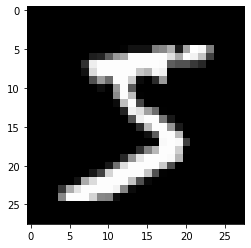

In [5]:
# Loading data
def get_data(file_path, file_name):
    with gzip.open(os.path.join(file_path, file_name), 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

    return x_train, y_train, x_valid, y_valid

filepath = ""
filename = ""
x_train, y_train, x_valid, y_valid = get_data(filepath,filename)


def display_image(img):
    if not torch.is_tensor(img):
        img = np.array(img,dtype='float')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    plt.show()
    
display_image(x_train[0])

4968


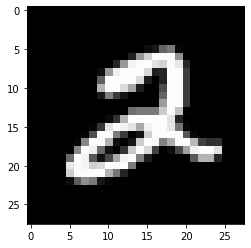

In [6]:
# Learning only the digit 2 first
digit_2_index = (y_train ==2)
digit_2_train = x_train[digit_2_index]
print(len(digit_2_train))
display_image(digit_2_train[0])

784 torch.Size([784, 64])


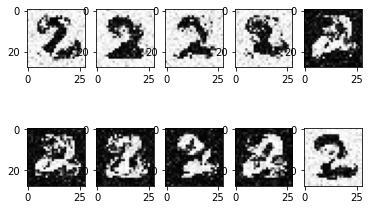

In [7]:
# Training loop

x = digit_2_train

def update_weights(v,h,v_,h_,W):
    W += learning_rate*(v.mm(h.T) - v_.mm(h_.T))

def update_bias(v,h,v_,h_,a,b):
    a += learning_rate*(v - v_)
    b += learning_rate*(h - h_)

def train(x):
    for i in range(epochs):
        total_batches = int(len(x)/batch_size)
        for j in range(total_batches):
            batch = x[j*batch_size:(j+1)*batch_size]

            # clamping batch to visible vectors
            v = torch.FloatTensor(batch).T
            # sample hidden units
            hidden_probs_ = hidden_probs(v)
            h = sample_hidden_units(hidden_probs_)

            # sample v_recon
            v_recon_probs = visible_probs(h)
            v_ = sample_visible_units(v_recon_probs)

            # sample h_recon
            h_recon_probs = hidden_probs(v_)
#             h_ = sample_hidden_units(h_recon_probs)
            h_ = h_recon_probs

            update_weights(v,h,v_,h_,W)
            update_bias(v,h,v_,h_,a,b)
#             print("Energy after batch {} = {}".format(j,energy()))

train(x)

#sampling digits from trained model
v_recon_probs = visible_probs(h)
v_ = sample_visible_units(v_recon_probs)
print(len(v_),v_.shape)

# taking samples
def display_multiple_images(x,plot_len = 2,plot_width = 5):
    k = 0
    f, ax = plt.subplots(plot_len,plot_width)
    for i in range(plot_len):
        for j in range(plot_width):
            img = x[k]
            pixels = img.reshape((28,28))
            ax[i,j].imshow(pixels,cmap='gray')
            k+=1
    plt.show()
display_multiple_images(v_.T)

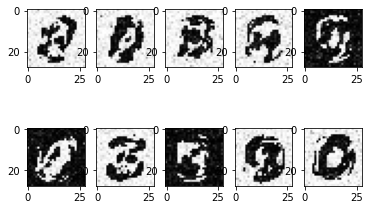

In [8]:
# Retraining for entire MNIST:
W = torch.randn([visible_vector_size,hidden_vector_size])*math.sqrt(2/visible_vector_size)
b = torch.randn([hidden_vector_size,batch_size])*math.sqrt(2/hidden_vector_size)
a = torch.randn([visible_vector_size,batch_size])*math.sqrt(2/visible_vector_size)

train(x_train)


#sampling digits from trained model
v_recon_probs = visible_probs(h)
v_ = sample_visible_units(v_recon_probs)
display_multiple_images(v_.T)


How the code could have been better:
1. class structure
2. proper training loop

Observations:
1. the gradients I derived, should always decrease the energy but sometimes they are making it increase sometimes decrease. Two further interesting points:
2. When I use ContinuousBernoulli to sample the learning is much faster and samples are sharper. 
3. sampling the last hidden vector doesnt really have much effect.

Feelings:
1. The science behind model is good but in the end we end up using approximations and tricks to get good samples. The generative part of the model does give good reconstruction. 

Understandings:
1. RBM learns through the transformation of information from hidden to visible vectors and vice versa using matrix transformations.
2. Maybe we are using the wrong cost function of neg log likelihood to change the energy. Maybe use KL-Divergence or reconstruction difference as cost functions.
3. It is learning its parameters ni a such a way that using the hidden units we can recreate our data. If we can recreate our data that means we understand its distribution.
4. I am not sure why we chose the logistic(sigmoid) function? to convert our results to probabilities? Is there any deeper reason behind it or is it just for computational convenience?
5. The negative part of the part of the gradients is what Geoffery Hinton says are unlearning what it has learned about the model(the kind of unlearning that happens in dreams). According to him, Boltzmann machine are about *finding the data less surprising* :)

Resources:
1. Nice introduction and overview of RBMs: https://www.youtube.com/watch?v=Fkw0_aAtwIw&t=13s
2. For detailed mathematical dive in the future check out the series by this guy: https://www.youtube.com/watch?v=p4Vh_zMw-HQ
3. Lecture by the father himself, 11.5 to 12.5: https://www.youtube.com/watch?v=5jaBneYd5Ig&t=616s
4. Guide for training RBMs : http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
5. Wikipedia : https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine